# DQN

In [1]:
import matplotlib
import random
import datetime

from collections import deque, namedtuple
from itertools import count
from time import time
from sklearn.metrics import classification_report

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [3]:
import sys
# sys.path.append(r"/Users/toshi/Documents/school/machine-learning")
# sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")

import flowdata
import flowenv

data, info = flowdata.flow_data.using_multiple_data()
raw_data_train = data[0]
raw_data_test = data[1]

# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/MultiFlow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/MultiFlow-v1", data=raw_data_test)

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(figsize=(15,5))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("ratio")
    # plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

In [7]:
def write_action_and_answer(episode=None, actions=None, answers=None, test=False):
    all_data = []
    class_name = flowdata.flow_data.label_info()
    if test:
        file_name = "action_and_answer_test.csv"
        report_dict = classification_report(
            answers, actions, labels=[i for i in range(len(class_name))], 
            target_names=class_name, output_dict=True, zero_division=0
        )

        for class_, metrics in report_dict.items():
            if class_ in class_name:
                entry = {
                    "episode": episode,
                    "class": class_,
                    "precision": metrics["precision"],
                    "recall": metrics["recall"],
                    "f1-score": metrics["f1-score"],
                    "support": metrics["support"]
                }
                all_data.append(entry)
        df = pd.DataFrame(all_data)
        df.to_csv(file_name, mode="w", header=False)
        return
    
    file_name = "action_and_answer.csv"
    # y_true: answer, y_pred: action
    for i, (y_true, y_pred) in enumerate(zip(answers, actions)):
        report_dict = classification_report(y_true, y_pred, labels=[i for i in range(len(class_name))], target_names=class_name, output_dict=True, zero_division=0)
        for class_, metrics in report_dict.items():
            if class_ in class_name:
                entry = {
                    "episode": i,
                    "class": class_,
                    "precision": metrics["precision"],
                    "recall": metrics["recall"],
                    "f1-score": metrics["f1-score"],
                    "support": metrics["support"]
                }
                all_data.append(entry)
    
    df = pd.DataFrame(all_data)
    df.to_csv(file_name, mode="w", header=False)

## Network

In [8]:
class DQNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Constants

In [9]:
UPDATE_TARGET_STEPS = 200
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-5

## Variables

In [10]:
num_episodes = 1000
n_actions = train_env.action_space.n
n_inputs = train_env.observation_space.shape[0]

state, info = train_env.reset()
# print(info)

policy_net = DQNetwork(n_inputs, n_actions).to(device)
target_net = DQNetwork(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
steps_done = 0

memory = ReplayMemory(10000)
episode_rewards = []
episode_precision = []
episode_action = []
episode_answer = []

## Functions

In [11]:
def select_action(state_tensor: torch.Tensor):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_tensor).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()

## Main loop

In [19]:
num_episodes = 15000

<Figure size 640x480 with 0 Axes>

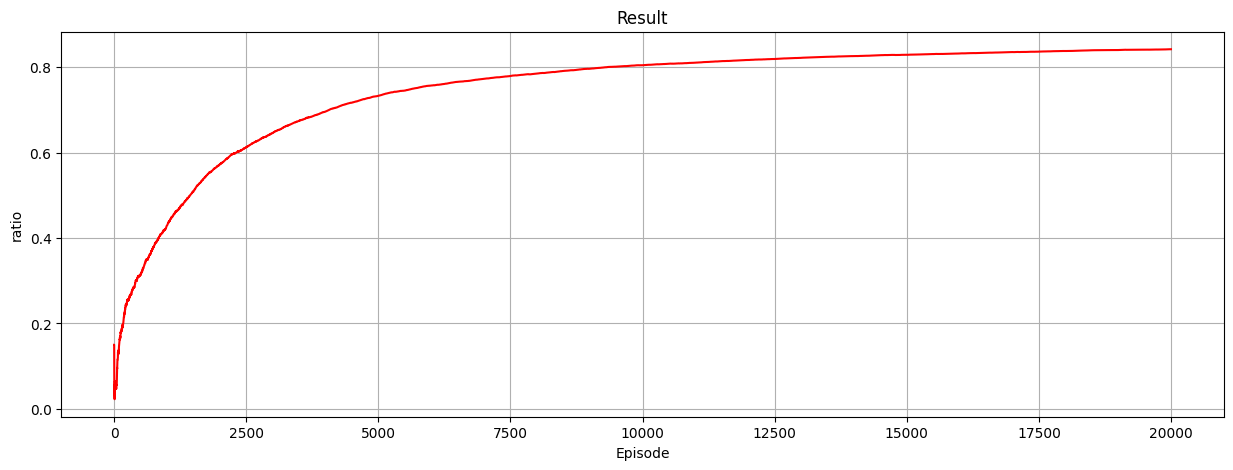

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
count_action = []
count_answer = []

for i_episode in range(num_episodes):
    # Initialize the environment and state
    random.seed(i_episode)
    sum_reward = 0
    confusion_matrix = np.zeros((2,2), dtype=int)

    count_action = []
    count_answer = []

    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action = select_action(state)

        # print(action)
        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        count_action.append(info["action"])
        count_answer.append(info["answer"])

        row_column_index = info["confusion_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1

        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        # optimize the model
        optimize_model()

        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    episode_action.append(count_action)
    episode_answer.append(count_answer)
    # episode_rewards.append(sum_reward)
    base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[0,0] / base if base != 0 else 0
    )
    # print(i_episode)
    if i_episode > 0 and i_episode % 10 == 0:
        plot_rewards(episode_precision)

# complete the episode
write_action_and_answer(actions=episode_action, answers=episode_answer)
plot_rewards(episode_precision, show_result=True)
torch.save(policy_net.state_dict(), "dqn_no2.pth")  # save the model

train_env.close()

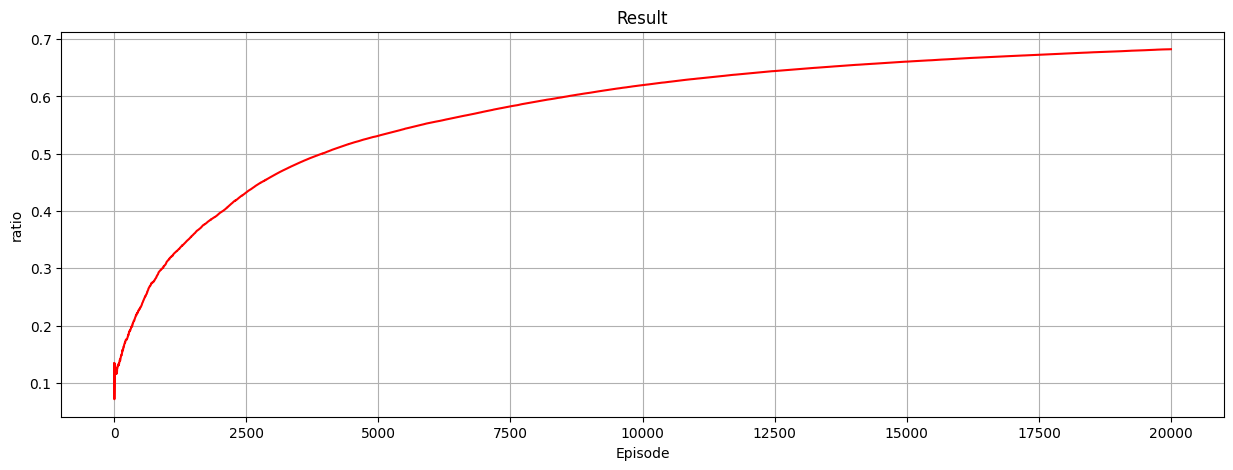

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
plot_rewards(episode_rewards, show_result=True)
torch.save(policy_net.state_dict(), "dqn_multi_no1.pth")  # save the model

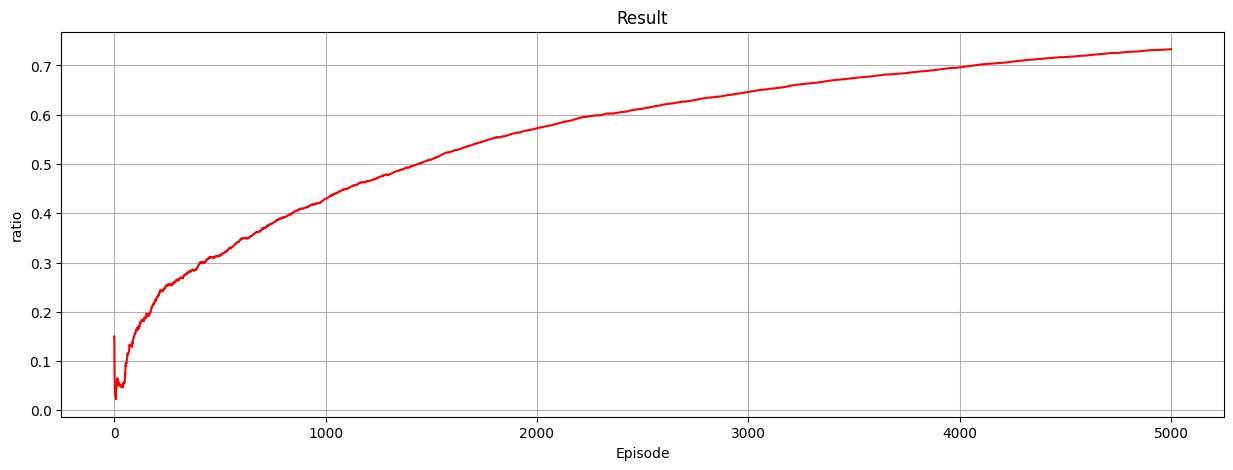

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
plot_rewards(episode_precision, show_result=True)
write_action_and_answer(actions=episode_action, answers=episode_answer)
# print(episode_action)

## Test the model

951 8591 57027 28902 0
952 8596 57082 28929 0
953 8596 57082 28930 0
954 8615 57197 29001 0
955 8619 57252 29024 0
956 8621 57327 29052 0
957 8629 57381 29075 0
958 8629 57384 29079 0
959 8640 57461 29110 0
960 8646 57512 29133 0
961 8653 57579 29161 0
962 8660 57617 29178 0
963 8681 57782 29277 0
964 8683 57809 29293 0
965 8691 57887 29336 0
966 8702 57933 29365 0
967 8713 57950 29375 0
968 8719 58000 29404 0
969 8737 58070 29443 0
970 8753 58192 29504 0
971 8795 58498 29629 0
972 8808 58567 29659 0
973 8812 58589 29674 0
974 8833 58725 29755 0
975 8840 58768 29787 0
976 8842 58770 29795 0
977 8848 58822 29822 0
978 8852 58899 29849 0
979 8853 58924 29867 0
980 8856 58941 29875 0
981 8878 59071 29926 0
982 8880 59079 29929 0
983 8882 59098 29936 0
984 8889 59139 29951 0
985 8894 59160 29959 0
986 8897 59186 29971 0
987 8904 59236 29993 0
988 8911 59295 30029 0
989 8916 59327 30049 0
990 8917 59339 30056 0
991 8938 59447 30110 0
992 8940 59463 30119 0
993 8948 59511 30142 0
994 8949 59

<Figure size 640x480 with 0 Axes>

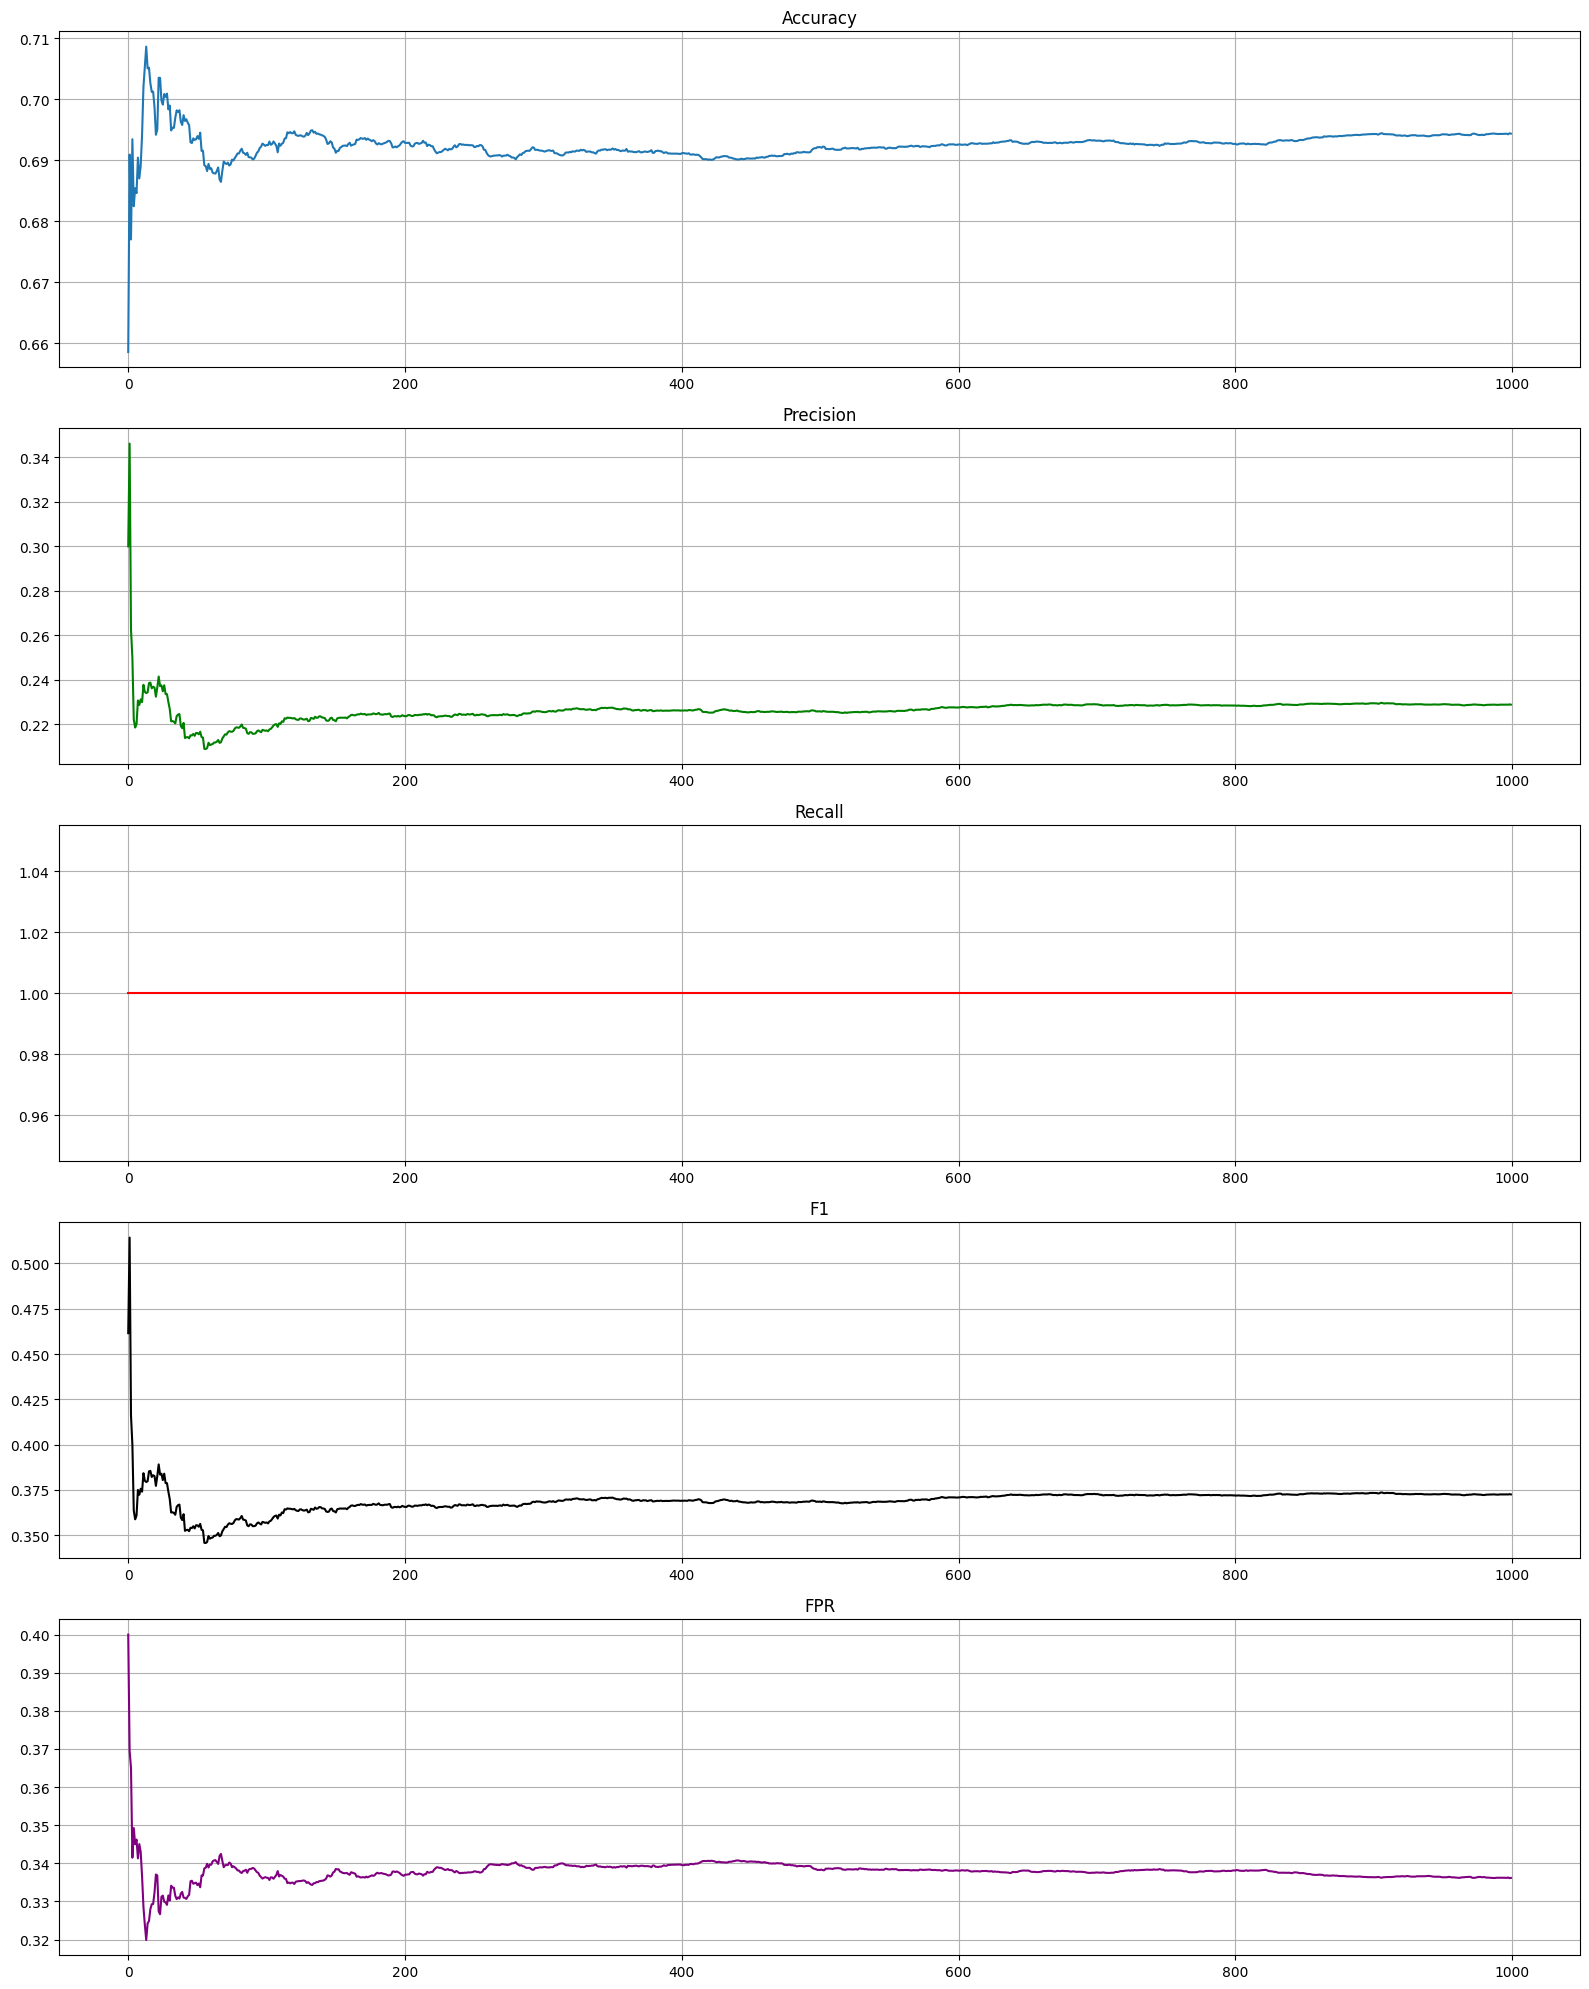

<Figure size 640x480 with 0 Axes>

 accuracy: 0.694342054907648
precision: 0.22889301049315278
  recall : 1.0
    f1   : 0.3725190208402249
   fpr   : 0.33615772276679406


<Figure size 640x480 with 0 Axes>

In [23]:
MODEL_PATH = "dqn_multi_no1.pth"

# load the model
trained_network = DQNetwork(n_inputs=n_inputs, n_outputs=n_actions).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

count_action = []
count_answer = []

for i_loop in range(1000):
    random.seed(i_loop)
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)


    for t in count():
        with torch.no_grad():
            test_action = trained_network(test_state).max(1).indices.view(1, 1)

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        count_action.append(test_info["action"])
        count_answer.append(int(test_info["answer"]))

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[0, 0]
    tn = confusion_array[1, 1]
    fp = confusion_array[0, 1]
    fn = confusion_array[1, 0]
    print(i_loop, tp, tn, fp, fn)

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)
    # print(accuracy, precision, recall, f1, fpr)

    

    if i_loop % 50 == 0:
        plot_metrics(metrics_dictionary)

write_action_and_answer(actions=count_action, answers=count_answer, test=True)
# plot metrics
plot_metrics(metrics_dictionary, show_result=True)
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")

In [17]:
write_action_and_answer(episode=1000, actions=count_action, answers=count_answer, test=True)

In [24]:
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")

 accuracy: 0.694342054907648
precision: 0.22889301049315278
  recall : 1.0
    f1   : 0.3725190208402249
   fpr   : 0.33615772276679406
